**Seed 고정**

In [ ]:
import tensorflow as tf
import numpy as np
import random
import torch
import os

In [ ]:
class config:
    seed = 42
    device = "cuda:0"    
        
    lr = 1e-3
    epochs = 25
    batch_size = 32
    num_workers = 4
    train_5_folds = True

In [ ]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

seed_everything(config.seed)

**전처리**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import libraries
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import os
import numpy as np
import pandas as pd
import math, random
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('whitegrid')
from scipy import stats
import missingno as msno

# display all columns
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_row', None)

In [ ]:
# load data
train_data = pd.read_csv('/content/drive/MyDrive/최종프로젝트/physionet2012_train.csv')
valid_data = pd.read_csv('/content/drive/MyDrive/최종프로젝트/physionet2012_valid.csv')
test_data = pd.read_csv('/content/drive/MyDrive/최종프로젝트/physionet2012_test.csv')

train_data.drop(['Unnamed: 0'], axis=1, inplace=True)
valid_data.drop(['Unnamed: 0'], axis=1, inplace=True)
test_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
# labeling
# train_data
train_data['label'] = 0
train_data.loc[(2 <= train_data['survival'])&(train_data['survival'] <= train_data['LOS']), 'label'] = 1
train_data.loc[train_data['survival'] > train_data['LOS'], 'label'] = 0
train_data.loc[train_data['survival'] == -1, 'label'] = 0

# valid_data
valid_data['label'] = 0
valid_data.loc[(2 <= valid_data['survival'])&(valid_data['survival'] <= valid_data['LOS']), 'label'] = 1
valid_data.loc[valid_data['survival'] > valid_data['LOS'], 'label'] = 0
valid_data.loc[valid_data['survival'] == -1, 'label'] = 0

# test_data
test_data['label'] = 0
test_data.loc[(2 <= test_data['survival'])&(test_data['survival'] <= test_data['LOS']), 'label'] = 1
test_data.loc[test_data['survival'] > test_data['LOS'], 'label'] = 0
test_data.loc[test_data['survival'] == -1, 'label'] = 0

In [ ]:
train_df = train_data.copy()
valid_df = valid_data.copy()
test_df = test_data.copy()

In [ ]:
# ffill
train_df.groupby(['pid']).fillna(method='ffill', inplace=True)
valid_df.groupby(['pid']).fillna(method='ffill', inplace=True)
test_df.groupby(['pid']).fillna(method='ffill', inplace=True)

""


In [ ]:
# median
train_df.fillna(train_df.median(), inplace=True)
valid_df.fillna(valid_df.median(), inplace=True)
test_df.fillna(test_df.median(), inplace=True)

In [ ]:
# Gender -1값 1로 바꾸기
train_df.loc[train_df['Gender']==-1, 'Gender'] = 1 

In [ ]:
train_df.drop(columns=['rec_time', 'Tropl', 'TropT', 'male', 'female', 'survival', 'surv_los', 'LOS'], inplace=True)
valid_df.drop(columns=['rec_time', 'Tropl', 'TropT', 'male', 'female', 'survival', 'surv_los', 'LOS'], inplace=True)
test_df.drop(columns=['rec_time', 'Tropl', 'TropT', 'male', 'female', 'survival', 'surv_los', 'LOS'], inplace=True)

In [ ]:
# train
pad_train_df = pd.DataFrame(columns = train_df.columns)
p = train_df['pid'].unique()
max_len = 70
for ep in p:
    if len(train_df[train_df['pid']==ep]) >= max_len:
        df = train_df[train_df['pid']==ep][:max_len]
        pad_train_df = pd.concat([pad_train_df, df])
    else:
        empty_df = pd.DataFrame(index=range(0,70), columns = train_df.columns) 
        empty_df[['pid']] = ep
        empty_df[['age']] = train_df[train_df['pid']==ep]['age'].values[0]
        empty_df[['Gender']] = train_df[train_df['pid']==ep]['Gender'].values[0]
        empty_df[['ICUType']] = train_df[train_df['pid']==ep]['ICUType'].values[0]
        empty_df[['label']] = train_df[train_df['pid']==ep]['label'].values[0]
        empty_df.iloc[-len(train_df[train_df['pid']==ep]):] = train_df[train_df['pid']==ep]
        empty_df.fillna(0, inplace=True)
        pad_train_df = pd.concat([pad_train_df, empty_df])

# valid
pad_valid_df = pd.DataFrame(columns = valid_df.columns)
p = valid_df['pid'].unique()
max_len = 70
for ep in p:
    if len(valid_df[valid_df['pid']==ep]) >= max_len:
        df = valid_df[valid_df['pid']==ep][:max_len]
        pad_valid_df = pd.concat([pad_valid_df, df])
    else:
        empty_df = pd.DataFrame(index=range(0,70), columns = valid_df.columns) 
        empty_df[['pid']] = ep
        empty_df[['age']] = valid_df[valid_df['pid']==ep]['age'].values[0]
        empty_df[['Gender']] = valid_df[valid_df['pid']==ep]['Gender'].values[0]
        empty_df[['ICUType']] = valid_df[valid_df['pid']==ep]['ICUType'].values[0]
        empty_df[['label']] = valid_df[valid_df['pid']==ep]['label'].values[0]
        empty_df.iloc[-len(valid_df[valid_df['pid']==ep]):] = valid_df[valid_df['pid']==ep]
        empty_df.fillna(0, inplace=True)
        pad_valid_df = pd.concat([pad_valid_df, empty_df])

# test
pad_test_df = pd.DataFrame(columns = test_df.columns)
p = test_df['pid'].unique()
max_len = 70
for ep in p:
    if len(test_df[test_df['pid']==ep]) >= max_len:
        df = test_df[test_df['pid']==ep][:max_len]
        pad_test_df = pd.concat([pad_test_df, df])
    else:
        empty_df = pd.DataFrame(index=range(0,70), columns = test_df.columns) 
        empty_df[['pid']] = ep
        empty_df[['age']] = test_df[test_df['pid']==ep]['age'].values[0]
        empty_df[['Gender']] = test_df[test_df['pid']==ep]['Gender'].values[0]
        empty_df[['ICUType']] = test_df[test_df['pid']==ep]['ICUType'].values[0]
        empty_df[['label']] = test_df[test_df['pid']==ep]['label'].values[0]
        empty_df.iloc[-len(test_df[test_df['pid']==ep]):] = test_df[test_df['pid']==ep]
        empty_df.fillna(0, inplace=True)
        pad_test_df = pd.concat([pad_test_df, empty_df])

In [ ]:
ohe_train_df = pd.get_dummies(pad_train_df, columns=['Gender', 'ICUType', 'MechVent'])
ohe_valid_df = pd.get_dummies(pad_valid_df, columns=['Gender', 'ICUType', 'MechVent'])
ohe_test_df = pd.get_dummies(pad_test_df, columns=['Gender', 'ICUType', 'MechVent'])

In [ ]:
ohe_train_df = ohe_train_df.astype('float')
ohe_valid_df = ohe_valid_df.astype('float')
ohe_test_df = ohe_test_df.astype('float')

In [ ]:
ordinary_train = ohe_train_df.copy()
ordinary_valid = ohe_valid_df.copy()
ordinary_test = ohe_test_df.copy()

In [ ]:
ordinary_train.drop(columns=['pid', 'label'], axis=1, inplace=True)
ordinary_valid.drop(columns=['pid', 'label'], axis=1, inplace=True)
ordinary_test.drop(columns=['pid', 'label'], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(ordinary_train)
scaled_train = scaler.transform(ordinary_train)
scaled_valid = scaler.transform(ordinary_valid)
scaled_test = scaler.transform(ordinary_test)
# scaled_train_df = pd.DataFrame(data=scaled_train, columns=ordinary_train.feature_names)

In [ ]:
# splitting dataset
train_X = scaled_train
train_y = ohe_train_df['label']

valid_X = scaled_valid
valid_y = ohe_valid_df['label']

test_X = scaled_test
test_y = ohe_test_df['label']

In [ ]:
print(train_X.shape, train_y.shape)

(226800, 41) (226800,)


In [ ]:
# imbalanced-learn 패키지
from imblearn.over_sampling import *
from imblearn.over_sampling import SMOTE

# 검증 데이터나 테스트 데이터가 아닌 학습데이터에서만 오버샘플링 사용할 것
# smote = SMOTE(random_state=0)
train_X_over, train_y_over = SMOTE(random_state=42).fit_resample(train_X, train_y)

In [ ]:
# reshape
print(train_X_over.shape, train_y_over.shape)
print(valid_X.shape, valid_y.shape)
print(test_X.shape, test_y.shape)

train_X_3d = train_X_over.reshape(-1, max_len, train_X_over.shape[-1])
train_y_3d = train_y_over[::70]
valid_X_3d = valid_X.reshape(-1, max_len, valid_X.shape[-1])
valid_y_3d = valid_y[::70]
test_X_3d = test_X.reshape(-1, max_len, test_X.shape[-1])
test_y_3d = test_y[::70]

print(train_X_3d.shape, train_y_3d.shape)
print(valid_X_3d.shape, valid_y_3d.shape)
print(test_X_3d.shape, test_y_3d.shape)

(393820, 41) (393820,)
(25200, 41) (25200,)
(28000, 41) (28000,)
(5626, 70, 41) (5626,)
(360, 70, 41) (360,)
(400, 70, 41) (400,)


In [ ]:
print(train_X_3d.shape, train_y_3d.shape)

(5626, 70, 41) (5626,)


In [ ]:
# setup
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_auc_score

from keras import layers
from keras import Sequential, Model
# from keras.preprocessing.sequence import pad_sequences
from pprint import pprint

from keras.models import Sequential             
from keras.layers import Dense, Dropout, BatchNormalization, SimpleRNN, LSTM, Bidirectional, BatchNormalization, Activation, GRU, Flatten, Conv1D, GlobalMaxPooling1D
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.optimizers import RMSprop, Adam
from keras import models
from keras import layers
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

In [ ]:
feature_dim = train_X_over.shape[-1]

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

# 1

In [ ]:
clf = lgb.LGBMClassifier(class_weight='balanced',drop_rate=0.9, min_data_in_leaf=100, max_bin=255,
                        n_estimators=500,min_sum_hessian_in_leaf=1,importance_type='gain',learning_rate=0.1,bagging_fraction = 0.85,
                        colsample_bytree = 1.0,feature_fraction = 0.1,lambda_l1 = 5.0,lambda_l2 = 3.0,max_depth =  9,
                        min_child_samples = 55,min_child_weight = 5.0,min_split_gain = 0.1,num_leaves = 45,subsample = 0.75)  

In [ ]:
clf = lgb.LGBMClassifier(class_weight='balanced',drop_rate=0.9, min_data_in_leaf=100, max_bin=255,
                        n_estimators=500,min_sum_hessian_in_leaf=1,importance_type='split',learning_rate=0.1,bagging_fraction = 0.85,
                        colsample_bytree = 1.0,feature_fraction = 0.1,lambda_l1 = 5.0,lambda_l2 = 3.0,max_depth =  9,
                        min_child_samples = 55,min_child_weight = 5.0,min_split_gain = 0.1,num_leaves = 45,subsample = 0.75)  

In [ ]:
clf.fit(train_X_over, train_y_over, early_stopping_rounds=100, eval_metric='auc', eval_set=(valid_X, valid_y), verbose=True)
clf_pred = clf.predict_proba(test_X)[:, 1]
score = roc_auc_score(test_y, clf_pred, average='macro')
print("ROC AUC: {0:.4f}".format(score))

[1]	valid_0's binary_logloss: 0.684031	valid_0's auc: 0.662113
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.677963	valid_0's auc: 0.659941
[3]	valid_0's binary_logloss: 0.668289	valid_0's auc: 0.646655
[4]	valid_0's binary_logloss: 0.644347	valid_0's auc: 0.632852
[5]	valid_0's binary_logloss: 0.670632	valid_0's auc: 0.627507
[6]	valid_0's binary_logloss: 0.695272	valid_0's auc: 0.620989
[7]	valid_0's binary_logloss: 0.69214	valid_0's auc: 0.61581
[8]	valid_0's binary_logloss: 0.72833	valid_0's auc: 0.608134
[9]	valid_0's binary_logloss: 0.722128	valid_0's auc: 0.615439
[10]	valid_0's binary_logloss: 0.711374	valid_0's auc: 0.627696
[11]	valid_0's binary_logloss: 0.705689	valid_0's auc: 0.644033
[12]	valid_0's binary_logloss: 0.695556	valid_0's auc: 0.658317
[13]	valid_0's binary_logloss: 0.683564	valid_0's auc: 0.673082
[14]	valid_0's binary_logloss: 0.677327	valid_0's auc: 0.672962
[15]	valid_0's binary_logloss: 0.677174	valid_0's auc

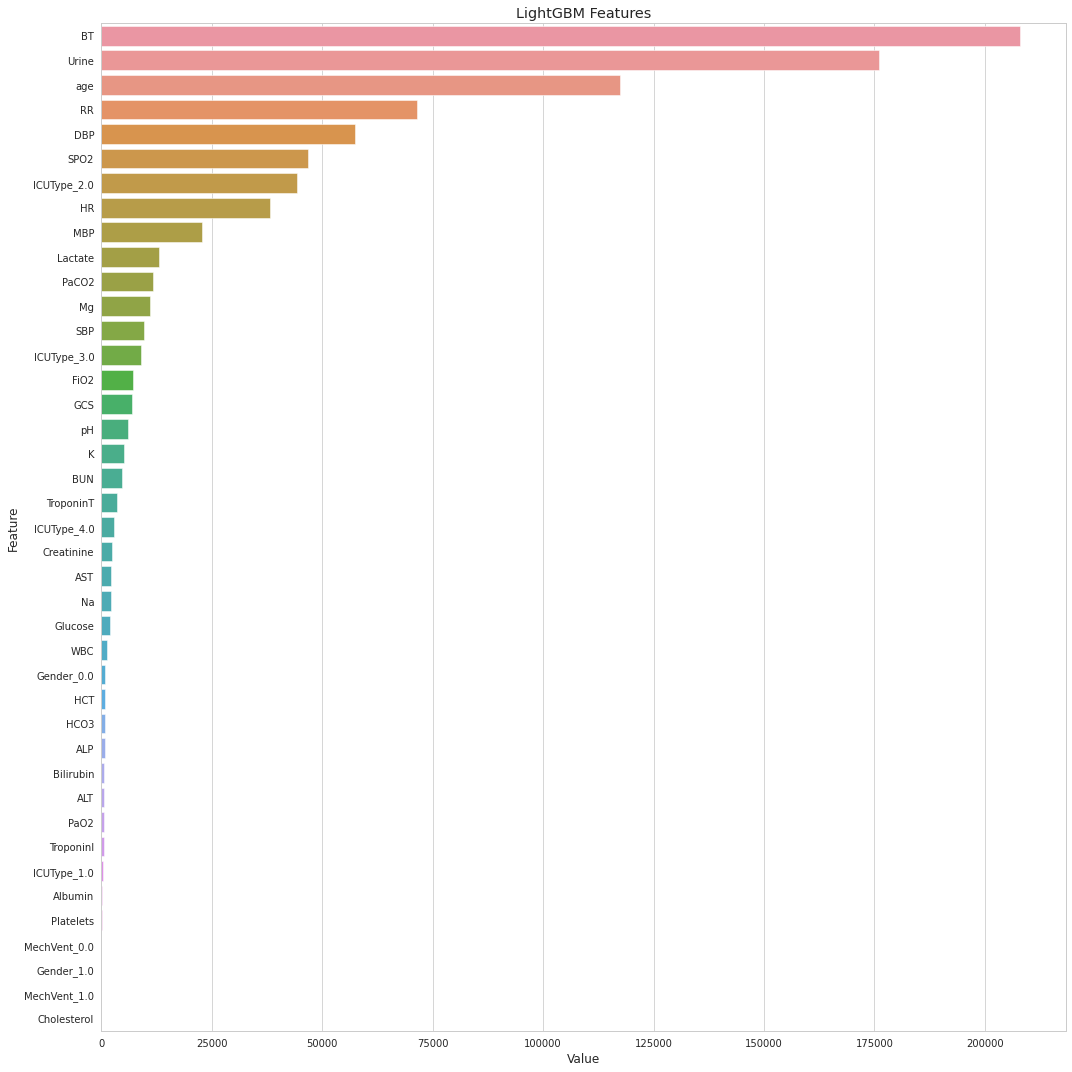

In [ ]:
# gain
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_, ordinary_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

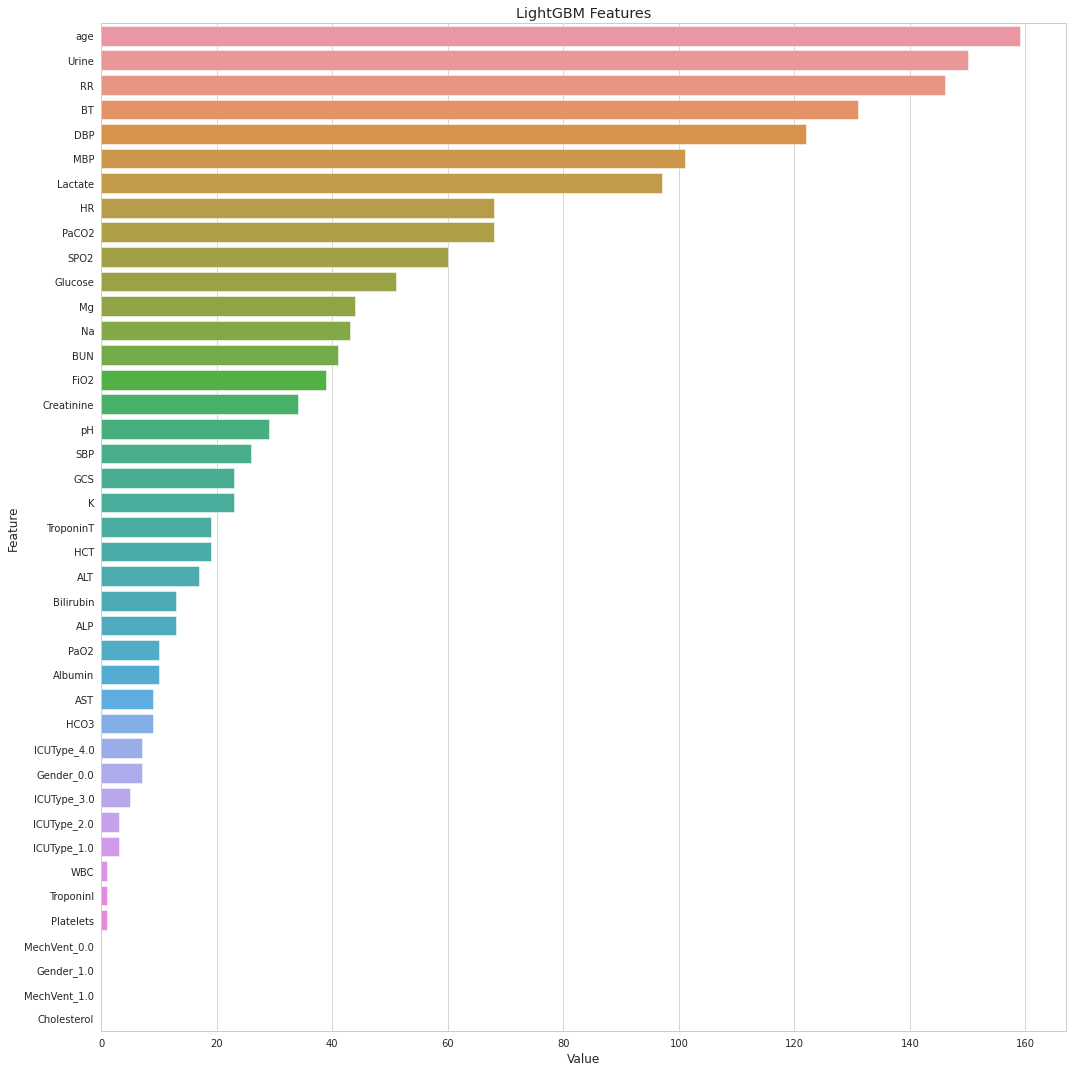

In [ ]:
# split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_, ordinary_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

# 2

In [ ]:
import lightgbm 

In [ ]:
train_data = lightgbm.Dataset(train_X_over, label=train_y_over)
valid_data = lightgbm.Dataset(valid_X, label=valid_y)
test_data = lightgbm.Dataset(test_X, label=test_y)

In [ ]:
#basic parameter:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 1
}

In [ ]:
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=valid_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[1]	valid_0's auc: 0.674844
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.679472
[3]	valid_0's auc: 0.685347
[4]	valid_0's auc: 0.689173
[5]	valid_0's auc: 0.693538
[6]	valid_0's auc: 0.696614
[7]	valid_0's auc: 0.703658
[8]	valid_0's auc: 0.714982
[9]	valid_0's auc: 0.718698
[10]	valid_0's auc: 0.730275
[11]	valid_0's auc: 0.729148
[12]	valid_0's auc: 0.735031
[13]	valid_0's auc: 0.733864
[14]	valid_0's auc: 0.735826
[15]	valid_0's auc: 0.733605
[16]	valid_0's auc: 0.730338
[17]	valid_0's auc: 0.727274
[18]	valid_0's auc: 0.72911
[19]	valid_0's auc: 0.728316
[20]	valid_0's auc: 0.730193
[21]	valid_0's auc: 0.73261
[22]	valid_0's auc: 0.733774
[23]	valid_0's auc: 0.730954
[24]	valid_0's auc: 0.729636
[25]	valid_0's auc: 0.727978
[26]	valid_0's auc: 0.729673
[27]	valid_0's auc: 0.727072
[28]	valid_0's auc: 0.726667
[29]	valid_0's auc: 0.728233
[30]	valid_0's auc: 0.725702
[31]	valid_0's auc: 0.724563
[32]	valid_0's auc: 0.724357
[33]	valid_0's auc: 

# 3

In [ ]:
plt.figure(figsize=(10,11))
plt.style.use('ggplot')

plt.rc('font', size=15)        # 기본 폰트 크기
plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('figure', titlesize=20) # figure title 폰트 크기

In [ ]:
# split
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=1000, num_leaves=50, subsample=0.8, min_child_samples=40, max_depth=15, importance_type = 'split')
lgbm.fit(train_X_over, train_y_over, early_stopping_rounds=100, eval_metric='auc', eval_set=(valid_X, valid_y), verbose=True)
lgbm_pred = lgbm.predict_proba(test_X)[:, 1]
score = roc_auc_score(test_y, lgbm_pred, average='macro')
print("ROC AUC: {0:.4f}".format(score))

[1]	valid_0's binary_logloss: 0.673818	valid_0's auc: 0.663443
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.657874	valid_0's auc: 0.669847
[3]	valid_0's binary_logloss: 0.645082	valid_0's auc: 0.675945
[4]	valid_0's binary_logloss: 0.634744	valid_0's auc: 0.673025
[5]	valid_0's binary_logloss: 0.625174	valid_0's auc: 0.676982
[6]	valid_0's binary_logloss: 0.616687	valid_0's auc: 0.675348
[7]	valid_0's binary_logloss: 0.610384	valid_0's auc: 0.675057
[8]	valid_0's binary_logloss: 0.603988	valid_0's auc: 0.676891
[9]	valid_0's binary_logloss: 0.597519	valid_0's auc: 0.682883
[10]	valid_0's binary_logloss: 0.591254	valid_0's auc: 0.686487
[11]	valid_0's binary_logloss: 0.585603	valid_0's auc: 0.689934
[12]	valid_0's binary_logloss: 0.579464	valid_0's auc: 0.695943
[13]	valid_0's binary_logloss: 0.5732	valid_0's auc: 0.697428
[14]	valid_0's binary_logloss: 0.568895	valid_0's auc: 0.699059
[15]	valid_0's binary_logloss: 0.564892	valid_0's au

<Figure size 1080x1080 with 0 Axes>

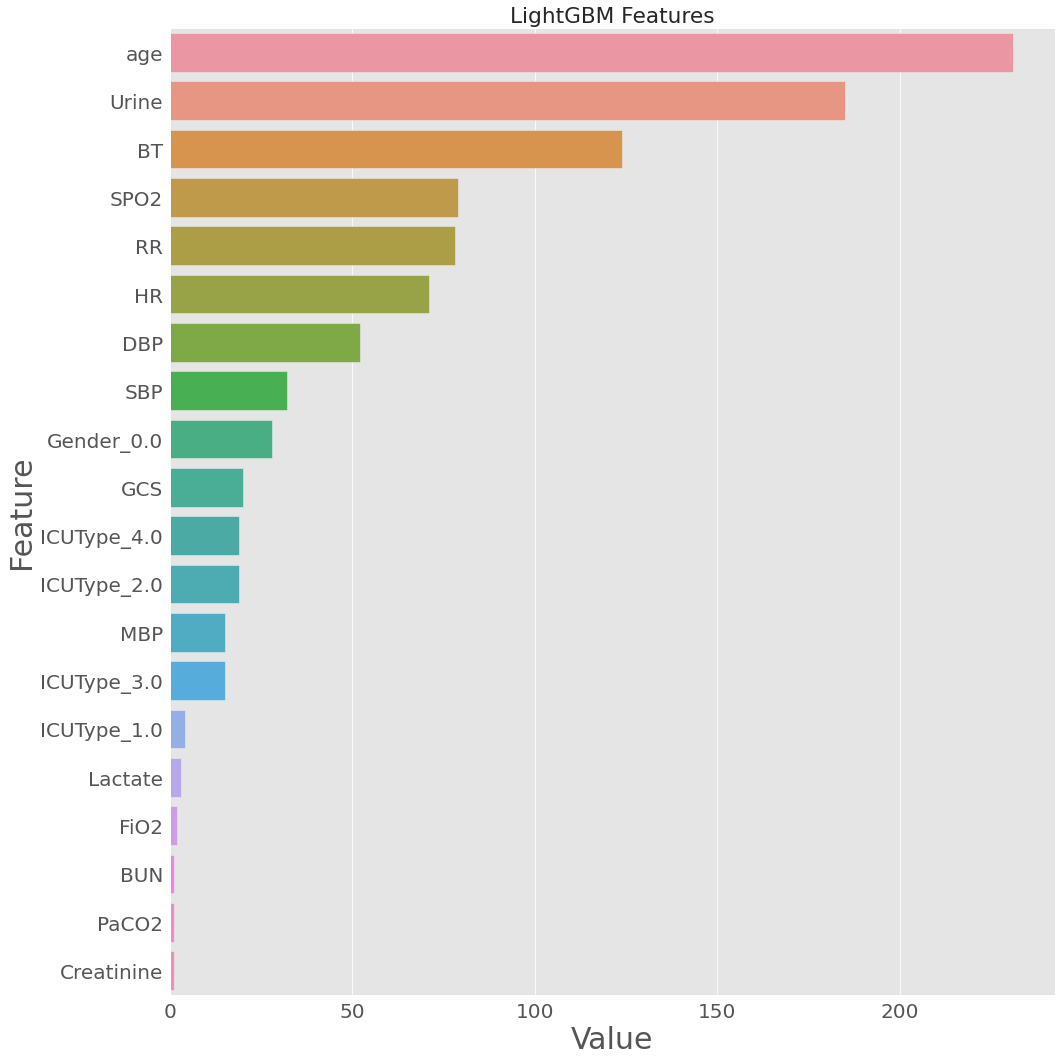

In [ ]:
plt.figure(figsize=(15,15))
plt.style.use('ggplot')

plt.rc('font', size=15)        # 기본 폰트 크기
plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('figure', titlesize=20) # figure title 폰트 크기
# split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, ordinary_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
# gain
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=1000, num_leaves=50, subsample=0.8, min_child_samples=40, max_depth=15, importance_type = 'gain')
lgbm.fit(train_X_over, train_y_over, early_stopping_rounds=100, eval_metric='auc', eval_set=(valid_X, valid_y), verbose=True)
lgbm_pred = lgbm.predict_proba(test_X)[:, 1]
score = roc_auc_score(test_y, lgbm_pred, average='macro')
print("ROC AUC: {0:.4f}".format(score))

[1]	valid_0's binary_logloss: 0.673818	valid_0's auc: 0.663443
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.657874	valid_0's auc: 0.669847
[3]	valid_0's binary_logloss: 0.645082	valid_0's auc: 0.675945
[4]	valid_0's binary_logloss: 0.634744	valid_0's auc: 0.673025
[5]	valid_0's binary_logloss: 0.625174	valid_0's auc: 0.676982
[6]	valid_0's binary_logloss: 0.616687	valid_0's auc: 0.675348
[7]	valid_0's binary_logloss: 0.610384	valid_0's auc: 0.675057
[8]	valid_0's binary_logloss: 0.603988	valid_0's auc: 0.676891
[9]	valid_0's binary_logloss: 0.597519	valid_0's auc: 0.682883
[10]	valid_0's binary_logloss: 0.591254	valid_0's auc: 0.686487
[11]	valid_0's binary_logloss: 0.585603	valid_0's auc: 0.689934
[12]	valid_0's binary_logloss: 0.579464	valid_0's auc: 0.695943
[13]	valid_0's binary_logloss: 0.5732	valid_0's auc: 0.697428
[14]	valid_0's binary_logloss: 0.568895	valid_0's auc: 0.699059
[15]	valid_0's binary_logloss: 0.564892	valid_0's au

<Figure size 1080x1080 with 0 Axes>

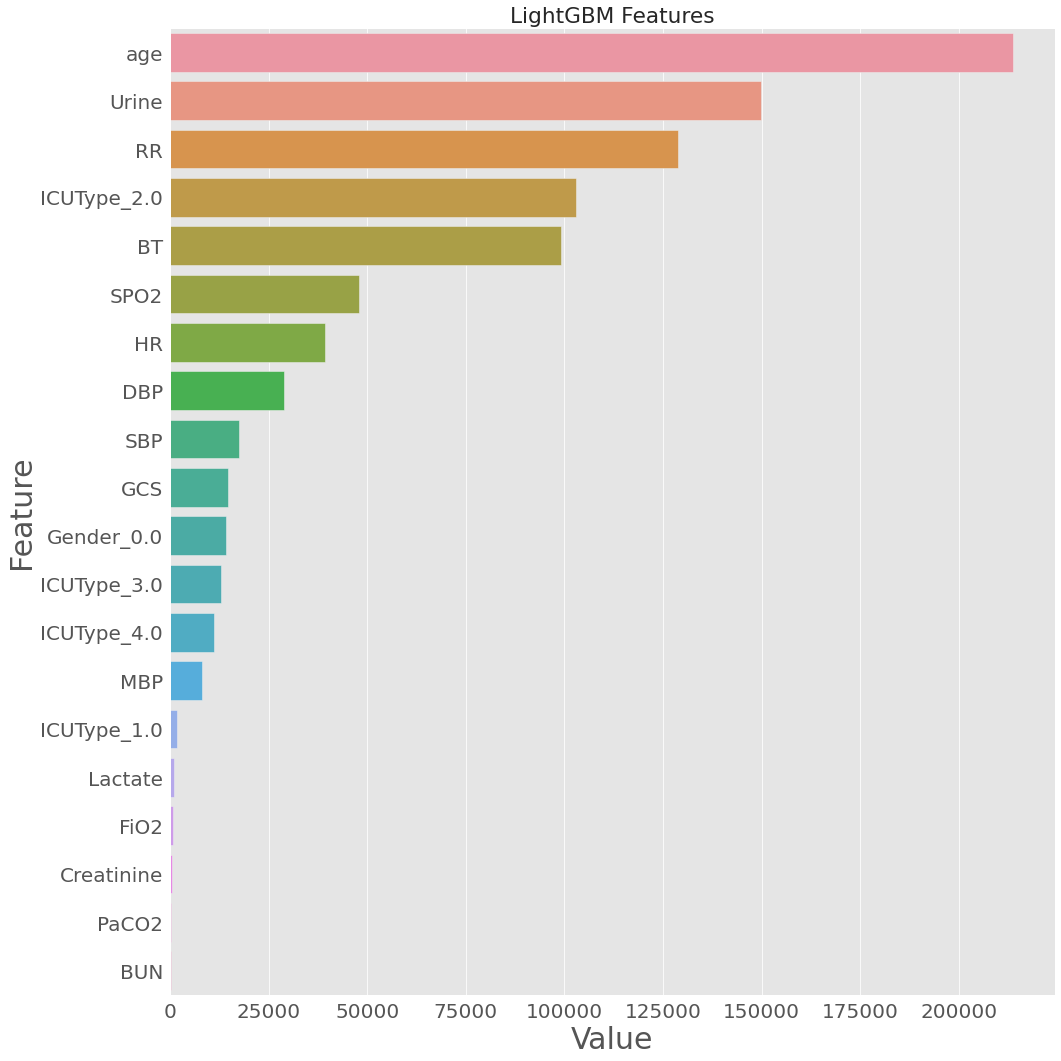

In [ ]:
plt.figure(figsize=(15,15))
plt.style.use('ggplot')

plt.rc('font', size=15)        # 기본 폰트 크기
plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('figure', titlesize=20) # figure title 폰트 크기
# gain
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, ordinary_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()